In [1]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 95% 163M/172M [00:04<00:00, 61.3MB/s]
100% 172M/172M [00:04<00:00, 40.2MB/s]


In [2]:
!unzip augmented-forest-segmentation.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segment

In [3]:
!pip install torchutils

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=970173ff3ee29fa34d558c3a1a00e8dbd18132880513726fa870a85360be74e1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c26a514155077014134f1415d283c1a0760d63621a1f14907398bfd462bd10f5
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [5]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary

import torchutils as tu
import matplotlib.pyplot as plt
from torch.nn.functional import relu

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import torch.utils.checkpoint as checkpoint

In [6]:
metadata_file = "/content/meta_data.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [7]:
train_val_paths, test_paths = train_test_split(metadata, test_size=0.2)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.15)

In [25]:
class ForestAerialImages(Dataset):
    directory = "/content/Forest Segmented/Forest Segmented/"

    def __init__(self, paths, image_transform=None, paired_transform=None):
        self.paths = paths.reset_index(drop=True)
        self.image_transform = image_transform
        self.paired_transform = paired_transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        row = self.paths.iloc[idx]
        img = cv2.imread(self.directory + "images/" + row["image"])[..., ::-1]
        mask = cv2.imread(self.directory + "masks/" + row["mask"], cv2.IMREAD_GRAYSCALE)

        if self.paired_transform:
            aug = self.paired_transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.image_transform:
            img = self.image_transform(img.copy())

        #mask = cv2.resize(mask, (68, 68), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask > 0).float().unsqueeze(0)

        return img, mask

In [27]:
paired_transform = A.Compose([
    A.Rotate(limit=45),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomToneCurve(),
    A.RandomBrightnessContrast()
], is_check_shapes=False)

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [28]:
train_ds = ForestAerialImages(train_paths, image_transform, paired_transform)
val_ds = ForestAerialImages(val_paths, image_transform)
test_ds = ForestAerialImages(test_paths, image_transform)

In [29]:
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_EVAL = 64

In [30]:
train_dl = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    num_workers=2, pin_memory=True
)

val_dl = DataLoader(
    val_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [32]:
model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", classes=1, activation="sigmoid", encoder_depth=5, decoder_channels=[512, 256, 64, 32, 16]).to(device)
for param in model.parameters():
    param.requires_grad_(True)

In [33]:
# class RandomTransform:
#     def __init__(self, transform):
#         self.transform = transform

#     def __call__(self, sample):
#         image, mask = sample
#         image = self.transform(image)
#         mask = self.transform(mask)
#         return image, mask

In [34]:
# train_image_transform = T.Compose([
#     T.RandomHorizontalFlip(p=0.5),
#     T.RandomVerticalFlip(p=0.5),
#     T.RandomRotation(45),
#     T.ToTensor()
# ])

# valid_transform = T.Compose([
#     T.ToTensor()
# ])

In [35]:
# class SegmentationDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.image_files = sorted(os.listdir(image_dir))
#         self.mask_files = sorted(os.listdir(mask_dir))

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         image_path = os.path.join(self.image_dir, self.image_files[idx])
#         mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

#         # Load image and mask
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

#         # Convert to PIL Image for compatibility with T.Compose
#         image = Image.fromarray(image)
#         mask = Image.fromarray(mask)

#         # Apply transformations
#         if self.transform:
#             image, mask = self.transform((image, mask))

#         return image, mask

In [36]:
# train_transform = RandomTransform(train_image_transform)
# valid_transform = RandomTransform(valid_transform)

In [37]:
# #Define Paths and Create Directories
# image_dir = '/content/Forest Segmented/Forest Segmented/images'
# mask_dir = '/content/Forest Segmented/Forest Segmented/masks'

# output_dirs = {
#     'train_images': '/content/Forest Segmented/train/images',
#     'train_masks': '/content/Forest Segmented/train/masks',
#     'val_images': '/content/Forest Segmented/val/images',
#     'val_masks': '/content/Forest Segmented/val/masks',
#     'test_images': '/content/Forest Segmented/test/images',
#     'test_masks': '/content/Forest Segmented/test/masks',
# }

# for path in output_dirs.values():
#     os.makedirs(path, exist_ok=True)

In [38]:
# #Get List of Files
# image_files = sorted(os.listdir(image_dir))
# mask_files = sorted(os.listdir(mask_dir))

# np.random.seed(42)
# indices = np.random.permutation(len(image_files))
# image_files = np.array(image_files)[indices]
# mask_files = np.array(mask_files)[indices]

In [39]:
# #Split into train (70%), val (15%), and test (15%)
# train_images, test_images, train_masks, test_masks = train_test_split(
#     image_files, mask_files, test_size=0.3, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     test_images, test_masks, test_size=0.5, random_state=42
# )

In [40]:
# #Move Files to Corresponding Directories
# def move_files(files, src_dir, dst_dir):
#     for file_name in files:
#         shutil.move(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))

# move_files(train_images, image_dir, output_dirs['train_images'])
# move_files(train_masks, mask_dir, output_dirs['train_masks'])

# move_files(val_images, image_dir, output_dirs['val_images'])
# move_files(val_masks, mask_dir, output_dirs['val_masks'])

# move_files(test_images, image_dir, output_dirs['test_images'])
# move_files(test_masks, mask_dir, output_dirs['test_masks'])

In [41]:
# train_dataset = SegmentationDataset(
#     image_dir='/content/Forest Segmented/train/images',
#     mask_dir='/content/Forest Segmented/train/masks',
#     transform=train_transform
# )

# valid_dataset = SegmentationDataset(
#     image_dir='/content/Forest Segmented/val/images',
#     mask_dir='/content/Forest Segmented/val/masks',
#     transform=valid_transform
# )

# test_dataset = SegmentationDataset(
#     image_dir='/content/Forest Segmented/test/images',
#     mask_dir='/content/Forest Segmented/test/masks',
#     transform=valid_transform
# )

In [42]:
# # Set up your batch size
# batch_size = 32
# batch_size_eval = 64

# # Create DataLoaders for train, validation, and test datasets
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# valid_loader = DataLoader(valid_dataset, batch_size=batch_size_eval, shuffle=True)

# test_loader = DataLoader(test_dataset, batch_size=batch_size_eval, shuffle=True)

In [43]:
# DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# DEVICE

In [44]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [45]:
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.BCEWithLogitsLoss()

In [46]:
def get_metrics(output, mask):
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask.int(), mode='binary', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").cpu()
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").cpu()
    return iou_score, accuracy

In [47]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [48]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
    model.train()

    train_loss = AverageMeter()
    train_acc = AverageMeter()
    train_iou = AverageMeter()

    for train_instances, instance_labels in train_dl:
        # mover o lote e os rotulos para o mesmo dispositivo do modelo
        train_instances = train_instances.to(device)
        instance_labels = instance_labels.to(device)

        # fazer previsão com o modelo
        preds = model(train_instances)

        # zerar os gradientes para evitar acumular
        optimizer.zero_grad()

        # calcular função de perda
        loss = loss_fn(preds.float(), instance_labels.float())
        train_loss.update(loss.item(), len(train_instances))

        # calcular métricas
        iou, acc = get_metrics(preds, instance_labels)
        train_iou.update(iou.item(), len(train_instances))
        train_acc.update(acc.item(), len(train_instances))

        loss.backward()

        # aplicar a atualização dos parametros da rede baseado nos gradientes
        optimizer.step()
    return train_loss.avg, train_iou.avg, train_acc.avg

In [49]:
def validation_step(model, val_dl, loss_fn, device):
    # ativar modo de avaliação
    model.eval()

    val_loss = AverageMeter()
    val_acc = AverageMeter()
    val_iou = AverageMeter()

    with torch.no_grad():
        for val_instances, instance_labels in val_dl:
            # mover o lote e os rotulos para o mesmo dispositivo do modelo
            val_instances = val_instances.to(device)
            instance_labels = instance_labels.to(device)

            # fazer previsão com o modelo
            preds = model(val_instances)

            # calcular função de perda
            loss = loss_fn(preds.float(), instance_labels.float())
            val_loss.update(loss.item(), len(val_instances))

            # calcular métricas
            iou, acc = get_metrics(preds, instance_labels)
            val_iou.update(iou.item(), len(val_instances))
            val_acc.update(acc.item(), len(val_instances))
    return val_loss.avg, val_iou.avg, val_acc.avg

In [50]:
N_EPOCHS = 15

In [51]:
history = {
    "train_loss": [],
    "train_iou": [],
    "train_acc": [],
    "val_loss": [],
    "val_iou": [],
    "val_acc": [],
}

In [52]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [53]:
for epoch in range(N_EPOCHS):
    train_loss, train_iou, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss, val_iou, val_acc  = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["train_iou"].append(train_iou)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    history["val_acc"].append(val_acc)

    print(f"Época [{epoch + 1}/{N_EPOCHS}]")
    print("-" * 35)
    print(f"Train loss: {round(train_loss, 6):<7} | Train IoU: {round(train_iou, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7} | Valid. IoU: {round(val_iou, 6):<7}\n")


Época [1/15]
-----------------------------------
Train loss: 0.478959 | Train IoU: 0.701863
Valid. loss: 0.442077 | Valid. IoU: 0.736144

Época [2/15]
-----------------------------------
Train loss: 0.431834 | Train IoU: 0.739951
Valid. loss: 0.473402 | Valid. IoU: 0.683756

Época [3/15]
-----------------------------------
Train loss: 0.417949 | Train IoU: 0.747891
Valid. loss: 0.423072 | Valid. IoU: 0.747279

Época [4/15]
-----------------------------------
Train loss: 0.415507 | Train IoU: 0.748589
Valid. loss: 0.429803 | Valid. IoU: 0.755258

Época [5/15]
-----------------------------------
Train loss: 0.401387 | Train IoU: 0.756783
Valid. loss: 0.409489 | Valid. IoU: 0.749833

Época [6/15]
-----------------------------------
Train loss: 0.393787 | Train IoU: 0.762952
Valid. loss: 0.407411 | Valid. IoU: 0.761346

Época [7/15]
-----------------------------------
Train loss: 0.398119 | Train IoU: 0.758027
Valid. loss: 0.42396 | Valid. IoU: 0.739169

Época [8/15]
----------------------

In [54]:
# def fit(
#         model: torch.nn.Module,
#         n_epochs: int,
#         optimizer: torch.optim.Optimizer,
#         train_loader: DataLoader,
#         valid_loader: DataLoader,
#         criterion: torch.nn.Module
#         ) -> tuple[list, ...]:

#     train_loss = []
#     valid_loss = []
#     train_iou = []
#     valid_iou = []
#     train_accuracy = []
#     valid_accuracy = []

#     model.to(DEVICE)

#     for epoch in range(n_epochs):
#         print(f"{'-' * 13} Epoch {epoch+1} {'-' * 13}")

#         model.train()
#         train_epoch_loss = []
#         train_epoch_iou = []
#         train_epoch_accuracy = []

#         for images, labels in train_loader:
#             images = images.to(DEVICE)
#             labels = labels.to(DEVICE)

#             # Forward pass
#             y_pred = model(images)

#             # Calculate loss
#             loss = criterion(y_pred, labels)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Calculate metrics
#             pred_labels = torch.sigmoid(y_pred) > 0.5  # Assuming binary segmentation
#             iou_score, accuracy = get_metrics(pred_labels.cpu(), labels.cpu())

#             train_epoch_loss.append(loss.item())
#             train_epoch_iou.append(iou_score.item())
#             train_epoch_accuracy.append(accuracy.item())

#         train_loss.append(np.mean(train_epoch_loss))
#         train_iou.append(np.mean(train_epoch_iou))
#         train_accuracy.append(np.mean(train_epoch_accuracy))

#         # Validation phase
#         model.eval()
#         valid_epoch_loss = []
#         valid_epoch_iou = []
#         valid_epoch_accuracy = []

#         with torch.no_grad():
#             for images, labels in valid_loader:
#                 images = images.to(DEVICE)
#                 labels = labels.to(DEVICE)

#                 # Forward pass
#                 y_pred = model(images)

#                 # Calculate loss
#                 loss = criterion(y_pred, labels)

#                 # Calculate metrics
#                 pred_labels = torch.sigmoid(y_pred) > 0.5
#                 iou_score, accuracy = get_metrics(pred_labels.cpu(), labels.cpu())

#                 valid_epoch_loss.append(loss.item())
#                 valid_epoch_iou.append(iou_score.item())
#                 valid_epoch_accuracy.append(accuracy.item())

#         valid_loss.append(np.mean(valid_epoch_loss))
#         valid_iou.append(np.mean(valid_epoch_iou))
#         valid_accuracy.append(np.mean(valid_epoch_accuracy))

#         print(
#           f'Train: IoU {train_iou[-1]:.3f}, Accuracy {train_accuracy[-1]:.3f}, Loss {train_loss[-1]:.3f}\n'
#           f'Valid: IoU {valid_iou[-1]:.3f}, Accuracy {valid_accuracy[-1]:.3f}, Loss {valid_loss[-1]:.3f}')
#         print(f'{"-"*35}')

#     return train_loss, valid_loss, train_iou, valid_iou, train_accuracy, valid_accuracy

In [23]:
# logs = fit(model, 10, optimizer, train_loader, valid_loader, criterion)

------------- Epoch 1 -------------
Train: IoU 0.535, Accuracy 0.535, Loss 0.624
Valid: IoU 0.583, Accuracy 0.583, Loss 0.595
-----------------------------------
------------- Epoch 2 -------------
Train: IoU 0.535, Accuracy 0.535, Loss 0.615
Valid: IoU 0.583, Accuracy 0.583, Loss 0.615
-----------------------------------
------------- Epoch 3 -------------
Train: IoU 0.535, Accuracy 0.535, Loss 0.611
Valid: IoU 0.583, Accuracy 0.583, Loss 0.600
-----------------------------------
------------- Epoch 4 -------------
Train: IoU 0.534, Accuracy 0.534, Loss 0.612
Valid: IoU 0.583, Accuracy 0.583, Loss 0.621
-----------------------------------
------------- Epoch 5 -------------


KeyboardInterrupt: 

In [62]:
torch.save(model.state_dict(), "unet.pt")

In [55]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val')
    plt.plot( history['train_loss'], label='train')
    plt.title('Loss per epoch');
    plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

def plot_iou(history):
    plt.plot(history['train_iou'], label='train_iou')
    plt.plot(history['val_iou'], label='val_iou')
    plt.title('IoU per epoch');
    plt.ylabel('iou')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.plot(history['train_acc'], label='train_accuracy')
    plt.plot(history['val_acc'], label='val_accuracy')
    plt.title('Accuracy per epoch');
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

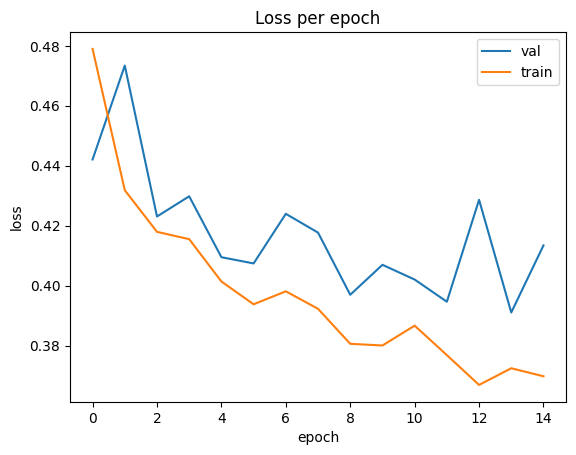

In [56]:
plot_loss(history)

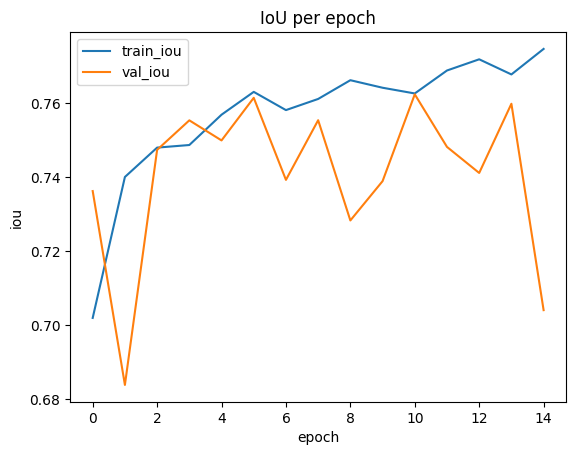

In [57]:
plot_iou(history)

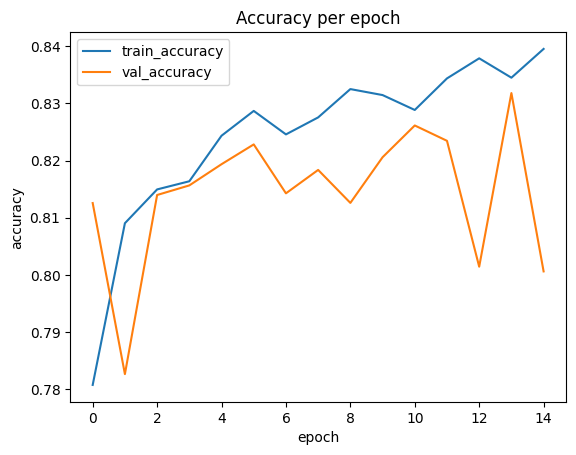

In [58]:
plot_accuracy(history)

In [59]:
test_loss, test_iou, test_acc  = validation_step(model, test_dl, loss_fn, device)
print(f"Test loss: {round(test_loss, 6):>7} | Test IoU: {round(test_iou, 6):>7} | Test accuracy: {round(test_acc, 6):>7}")

Test loss: 0.397679 | Test IoU: 0.730058 | Test accuracy:  0.8155


In [60]:
instances, targets = next(iter(test_dl))
with torch.no_grad():
    preds = (model(instances.to(device))).float().cpu()

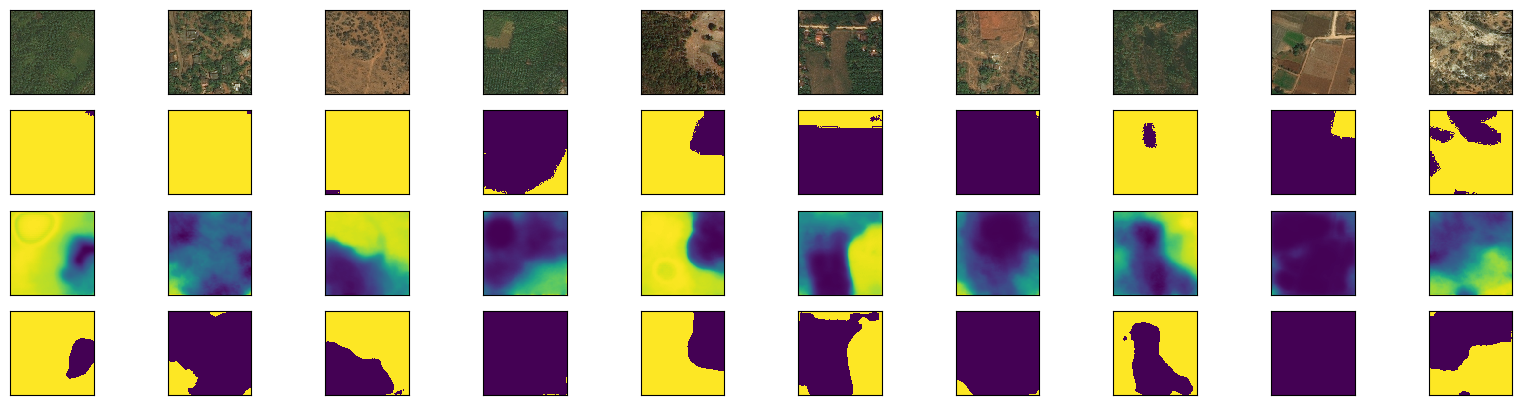

In [61]:
w = 10
fig, ax = plt.subplots(4, w, figsize=(20, 5))
for j in range(w):
    ax[0][j].imshow(0.5 + 0.5 * instances[j].permute(1, 2, 0), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow(targets[j][0], interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

    ax[2][j].imshow(preds[j][0], interpolation="None")
    ax[2][j].set_xticks([])
    ax[2][j].set_yticks([])

    ax[3][j].imshow((preds[j][0] > 0.5), interpolation="None")
    ax[3][j].set_xticks([])
    ax[3][j].set_yticks([])